In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.models.utils import output_to_visuals, add_negative_binomial
from covid19model.data import sciensano
from covid19model.visualization.output import color_timeframes
from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Load hospitalization data

In [2]:
# Hospitalization data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()

## Setup models with and without vaccination

In [3]:
# Settings
start_date = '2020-03-17'
n_age_groups = 10
agg = 'prov'
VOCs=['WT', 'abc']

In [4]:
vacc_model, samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(vaccination=True, age_stratification_size=n_age_groups, agg=agg, VOCs=VOCs, start_date=start_date)
model, samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(vaccination=False, age_stratification_size=n_age_groups, agg=agg, VOCs=VOCs, start_date=start_date)

## Simulate both models

In [5]:
# Settings
start_sim = start_date
end_sim = '2021-08-07'
start_data = '2020-09-01'
end_data = '2021-04-15'
N = 5
n_draws_per_sample = 100

In [6]:
import random
def draw_fnc(param_dict,samples_dict):
    """
    A function to draw samples from the estimated posterior distributions of the model parameters.
    Tailored for use with the spatial COVID-19 SEIQRD model with only the alpha VOC.

    """

    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    param_dict['beta_U'] = samples_dict['beta_U'][idx]  
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    param_dict['eff_schools'] = samples_dict['eff_schools'][idx]    
    param_dict['eff_home'] = samples_dict['eff_home'][idx]      
    param_dict['eff_work'] = samples_dict['eff_work'][idx]       
    param_dict['eff_rest'] = samples_dict['eff_rest'][idx]
    param_dict['mentality'] = samples_dict['mentality'][idx]
    param_dict['K_inf'] = np.array([samples_dict['K_inf_abc'][idx],], np.float64)
    param_dict['amplitude'] = samples_dict['amplitude'][idx]

    # Hospitalization
    # ---------------
    # Fractions
    names = ['c','m_C','m_ICU']
    for idx,name in enumerate(names):
        par=[]
        for jdx in range(len(param_dict['c'])):
            par.append(np.random.choice(samples_dict['samples_fractions'][idx,jdx,:]))
        param_dict[name] = np.array(par)
    # Residence times
    n=20
    distributions = [samples_dict['residence_times']['dC_R'],
                     samples_dict['residence_times']['dC_D'],
                     samples_dict['residence_times']['dICU_R'],
                     samples_dict['residence_times']['dICU_D'],
                     samples_dict['residence_times']['dICUrec']]

    names = ['dc_R', 'dc_D', 'dICU_R', 'dICU_D','dICUrec']
    for idx,dist in enumerate(distributions):
        param_val=[]
        for age_group in dist.index.get_level_values(0).unique().values[0:-1]:
            draw = np.random.gamma(dist['shape'].loc[age_group],scale=dist['scale'].loc[age_group],size=n)
            param_val.append(np.mean(draw))
        param_dict[names[idx]] = np.array(param_val)
    return param_dict

In [7]:
print('\n1) Simulating spatial COVID-19 SEIRD with vaccination '+str(N)+' times')
out_vacc = vacc_model.sim(end_sim,start_date=start_sim,N=N,draw_fcn=draw_fnc,samples=samples_dict, verbose=True)
print('\n2) Simulating spatial COVID-19 SEIRD without vaccination '+str(N)+' times')
out = model.sim(end_sim,start_date=start_sim,N=N,draw_fcn=draw_fnc,samples=samples_dict, verbose=True)
simtime = out['time'].values


1) Simulating spatial COVID-19 SEIRD with vaccination 5 times
Simulating draw 5/5
2) Simulating spatial COVID-19 SEIRD without vaccination 5 times


## Visualize result

In [8]:
alpha_scatter = 0.5
alpha_structural = 1/(2*N)
alpha_statistical = 0.15

In [9]:
H_in_mean, H_in_median, H_in_lower, H_in_upper = add_negative_binomial(out_vacc['H_in'].sum(dim=['Nc', 'place', 'doses']).values, alpha=float(samples_dict['dispersion']), n_draws_per_sample=n_draws_per_sample, add_to_mean=False)
H_tot_mean, H_tot_median, H_tot_lower, H_tot_upper = add_negative_binomial(out_vacc['H_tot'].sum(dim=['Nc', 'place', 'doses']).values, alpha=float(samples_dict['dispersion']), n_draws_per_sample=n_draws_per_sample, add_to_mean=False)

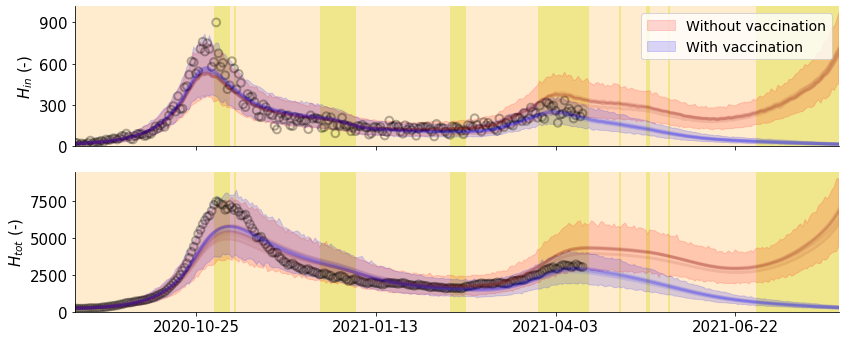

In [10]:
fig,ax=plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,5))

######################
## Model prediction ##
######################

for idx, state in enumerate(['H_in', 'H_tot']):
    mean, median, lower, upper = add_negative_binomial(out[state].sum(dim=['Nc', 'place', 'doses']).values, alpha=float(samples_dict['dispersion']), n_draws_per_sample=n_draws_per_sample, add_to_mean=False)
    ax[idx].fill_between(simtime, lower, upper, alpha=alpha_statistical, color='red')
    mean, median, lower, upper = add_negative_binomial(out_vacc[state].sum(dim=['Nc', 'place', 'doses']).values, alpha=float(samples_dict['dispersion']), n_draws_per_sample=n_draws_per_sample, add_to_mean=False)
    ax[idx].fill_between(simtime, lower, upper, alpha=alpha_statistical, color='blue')
    
for idx, state in enumerate(['H_in', 'H_tot']):
    y_model = out[state].sum(dim=['Nc', 'place', 'doses'])
    y_model_vacc = out_vacc[state].sum(dim=['Nc', 'place', 'doses'])
    # Plot model prediction
    for j in range(N):
        ax[idx].plot(simtime, y_model[j,:], color='maroon', linewidth=3, alpha=alpha_structural)
        ax[idx].plot(simtime, y_model_vacc[j,:], color='blue', linewidth=3, alpha=alpha_structural)
    #mean, median, lower, upper = add_negative_binomial(out[state].sum(dim=['Nc', 'place', 'doses']).values, alpha=float(samples_dict['dispersion']), n_draws_per_sample=n_draws_per_sample, add_to_mean=False)
    #ax[idx].plot(simtime, mean, '--', color='red')
    #mean, median, lower, upper = add_negative_binomial(out_vacc[state].sum(dim=['Nc', 'place', 'doses']).values, alpha=float(samples_dict['dispersion']), n_draws_per_sample=n_draws_per_sample, add_to_mean=False)
    #ax[idx].plot(simtime, mean, '--', color='blue') 

################
## Datapoints ##
################

# New hospitalizations
ax[0].scatter(df_hosp[start_sim:end_data].index,df_hosp['H_in'][start_sim:end_data], color='black', alpha=0.3, linestyle='None', facecolors='none', s=60, linewidth=2)
# Total hospitalizations
ax[1].scatter(df_hosp[start_sim:end_data].index,df_hosp['H_tot'][start_sim:end_data], color='black', alpha=0.3, linestyle='None', facecolors='none', s=60, linewidth=2)

################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
for i in range(len(ax)):
    color_timeframes(start_background, pd.Timestamp(2022, 1, 1), ax=ax[i], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

######################
## Make axes pretty ##
######################

# First axes
ax[0].grid(False)
ax[0].set_ylabel('$H_{in}$ (-)')
ax[0] = _apply_tick_locator(ax[0])
ax[0].set_ylim([0, None])
ax[0].legend(['Without vaccination', 'With vaccination'], loc='upper right', fontsize=14)

# Second axes
ax[1].grid(False)
ax[1].set_ylabel('$H_{tot}$ (-)')
ax[1].set_xlim([start_data, end_sim])
ax[1].set_ylim([0, None])
ax[1] = _apply_tick_locator(ax[0])

plt.tight_layout()
plt.show()
#fig.savefig('twallema-immunity-trends.pdf')
plt.close()